# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import csv
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from matplotlib import pyplot as plt
import seaborn as sns

from wordcloud import WordCloud


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1')
test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding='latin-1')

In [3]:
train.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


In [4]:
train.columns


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [5]:
train = train.drop(columns = 'UserName')
train = train.drop(columns = 'ScreenName')
train = train.drop(columns = 'Location')
train = train.drop(columns = 'TweetAt')


In [6]:
test = test.drop(columns = 'UserName')
test = test.drop(columns = 'ScreenName')
test = test.drop(columns = 'Location')
test = test.drop(columns = 'TweetAt')


In [7]:
train['Sentiment'].value_counts()


Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [8]:
train.shape, test.shape


((41157, 2), (3798, 2))

In [9]:
train0=train[train['Sentiment']=='Positive']
train1=train[train['Sentiment']=='Negative']
train2=train[train['Sentiment']=='Neutral']
train3=train[train['Sentiment']=='Extremely Positive']
train4=train[train['Sentiment']=='Extremely Negative']

In [10]:
train0.shape, train1.shape, train2.shape, train3.shape, train4.shape

((11422, 2), (9917, 2), (7713, 2), (6624, 2), (5481, 2))

# Pre-Processing Data

In [11]:
#Remove Hashtags
train['OriginalTweet'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)

#Remove Mention
train['OriginalTweet'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

#Remove URL
train['OriginalTweet'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

train['OriginalTweet']=train['OriginalTweet'].str.lower()

#Remove Punctuations
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [12]:
#Remove Hashtags
test['OriginalTweet'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)

#Remove Mention
test['OriginalTweet'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

#Remove URL
test['OriginalTweet'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

test['OriginalTweet']=test['OriginalTweet'].str.lower()

#Remove Punctuations
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [13]:
stemmer = PorterStemmer()
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [14]:
stop = stopwords.words('english')

train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Post EDA

In [15]:
train.head(20)

,OriginalTweet,Sentiment
0,httpstcoifz9fan2pa httpstcoxx6ghgfzcc httpstco...,Neutral
1,advic talk neighbour famili exchang phone numb...,Positive
2,coronaviru australia woolworth give elderli di...,Positive
3,food stock onli one empti pleas dont panic eno...,Positive
4,readi go supermarket dure outbreak becaus im p...,Extremely Negative
5,news regionâ first confirm covid19 case came ...,Positive
6,cashier groceri store wa share hi insight prov...,Positive
7,wa supermarket today didnt buy toilet paper ht...,Neutral
8,due covid19 retail store classroom atlanta ope...,Positive
9,corona preventionw stop buy thing cash use onl...,Negative


In [16]:
train.describe()

,OriginalTweet,Sentiment
count,41157,41157
unique,41056,5
top,,Positive
freq,15,11422


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [18]:
train.nunique()

OriginalTweet    41056
Sentiment            5
dtype: int64

In [19]:
train.shape

(41157, 2)

In [20]:
nullValues = (train.isnull().sum()/len(train)*100).sort_values(ascending = False)
nullValues

OriginalTweet    0.0
Sentiment        0.0
dtype: float64

In [21]:
# Replace "Extremely Positive" with "Positive"
train['Sentiment'] = train['Sentiment'].replace('Extremely Positive', 'Positive')

# Replace "Extremely Negative" with "Negative"
train['Sentiment'] = train['Sentiment'].replace('Extremely Negative', 'Negative')

In [22]:
# Replace "Extremely Positive" with "Positive"
test['Sentiment'] = test['Sentiment'].replace('Extremely Positive', 'Positive')

# Replace "Extremely Negative" with "Negative"
test['Sentiment'] = test['Sentiment'].replace('Extremely Negative', 'Negative')

In [23]:
sentimentClass = train['Sentiment'].value_counts();
sentimentClass

Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64

# **Distribution of sentiment categories using a bar plot**

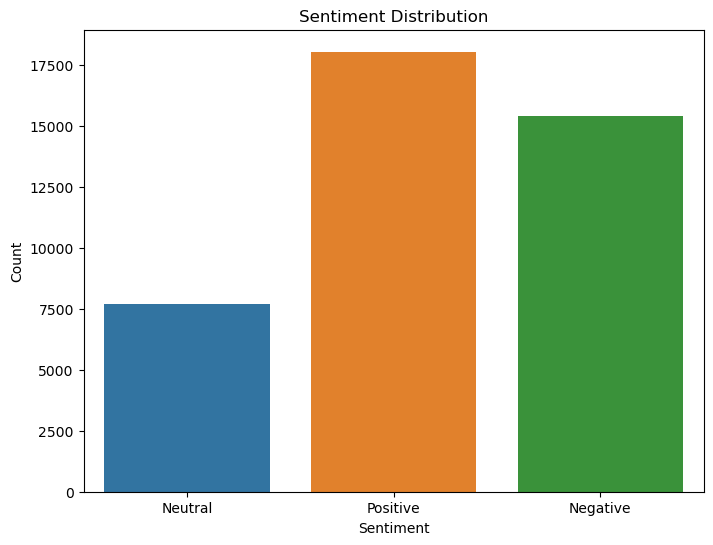

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='Sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Word Cloud

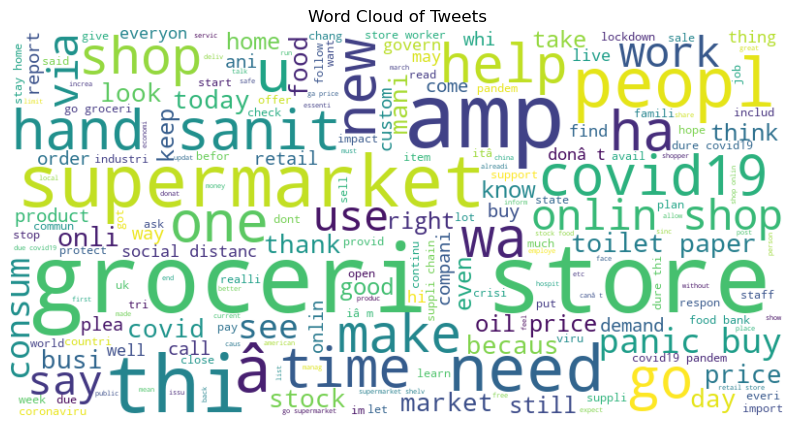

In [25]:
all_tweets_text = " ".join(tweet for tweet in train['OriginalTweet'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets_text)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

In [26]:
x = train['OriginalTweet']
y = train['Sentiment']

In [27]:
x.shape

(41157,)

# Vectorization

## TF-IDF 

In [28]:
corpus = []
for i in range(x.shape[0]):
    corpus.append(x.iloc[i])

In [29]:
vectorizer1 = TfidfVectorizer(max_features=1000)
X1 = vectorizer1.fit_transform(x)
feature_names1 = vectorizer1.get_feature_names_out()
denselist1 = X1.todense().tolist()
train = pd.DataFrame(denselist1, columns=feature_names1)

In [30]:
X_temp, X_test, y_temp, y_test = train_test_split(train, y, test_size=0.2, random_state=0)


In [31]:
accuracy = {'TF-IDF':[]}


# Models

## Logistic Regression

In [32]:
regressor_LR_tf = LogisticRegression(C=1.0,penalty='l2',solver='newton-cg')
regressor_LR_tf.fit(X_temp, y_temp)
y_predict_LR_tf = regressor_LR_tf.predict(X_test)
a=(regressor_LR_tf.score(X_test, y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_LR_tf))
print(metrics.classification_report(y_test, y_predict_LR_tf))
print(metrics.accuracy_score(y_test, y_predict_LR_tf))

[[2311  238  531]
 [ 232  995  299]
 [ 428  237 2961]]
              precision    recall  f1-score   support

    Negative       0.78      0.75      0.76      3080
     Neutral       0.68      0.65      0.66      1526
    Positive       0.78      0.82      0.80      3626

    accuracy                           0.76      8232
   macro avg       0.75      0.74      0.74      8232
weighted avg       0.76      0.76      0.76      8232

0.7612973760932945


## Decision Tree

In [33]:
model_DT_tf = DecisionTreeClassifier(criterion = 'gini', max_depth=2) 
model_DT_tf.fit(X_temp, y_temp)
y_predict_DT_tf = model_DT_tf.predict(X_test)
a=(model_DT_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_DT_tf))
print(metrics.classification_report(y_test, y_predict_DT_tf))
print(metrics.accuracy_score(y_test, y_predict_DT_tf))

[[ 593    0 2487]
 [  19    0 1507]
 [ 136    0 3490]]
              precision    recall  f1-score   support

    Negative       0.79      0.19      0.31      3080
     Neutral       0.00      0.00      0.00      1526
    Positive       0.47      0.96      0.63      3626

    accuracy                           0.50      8232
   macro avg       0.42      0.39      0.31      8232
weighted avg       0.50      0.50      0.39      8232

0.49599125364431484


## Gradient Boosting 

In [34]:
model_GB_tf = GradientBoostingClassifier(learning_rate= 0.1, max_depth=3, n_estimators= 100,subsample=1.0) 
model_GB_tf.fit(X_temp, y_temp)
y_predict_GB_tf = model_GB_tf.predict(X_test)
a=(model_GB_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_GB_tf))
print(metrics.classification_report(y_test, y_predict_GB_tf))
print(metrics.accuracy_score(y_test, y_predict_GB_tf))

[[1987  113  980]
 [ 217  464  845]
 [ 476  114 3036]]
              precision    recall  f1-score   support

    Negative       0.74      0.65      0.69      3080
     Neutral       0.67      0.30      0.42      1526
    Positive       0.62      0.84      0.72      3626

    accuracy                           0.67      8232
   macro avg       0.68      0.60      0.61      8232
weighted avg       0.68      0.67      0.65      8232

0.6665451895043731


## Random Forest

In [35]:
model_RF_tf = RandomForestClassifier(n_estimators= 100, max_features = 'log2')
model_RF_tf.fit(X_temp, y_temp)
y_predict_RF_tf = model_RF_tf.predict(X_test)
a=(model_RF_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_RF_tf))
print(metrics.classification_report(y_test, y_predict_RF_tf))
print(metrics.accuracy_score(y_test, y_predict_RF_tf))

[[2201  194  685]
 [ 245  906  375]
 [ 441  221 2964]]
              precision    recall  f1-score   support

    Negative       0.76      0.71      0.74      3080
     Neutral       0.69      0.59      0.64      1526
    Positive       0.74      0.82      0.77      3626

    accuracy                           0.74      8232
   macro avg       0.73      0.71      0.72      8232
weighted avg       0.74      0.74      0.74      8232

0.7374878522837707


## K Nearest Neighbour

In [36]:
model_KN_tf = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 5, weights= 'distance') 
model_KN_tf.fit(X_temp, y_temp)
y_predict_KN_tf = model_KN_tf.predict(X_test)
a=(model_KN_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_KN_tf))
print(metrics.classification_report(y_test, y_predict_KN_tf))
print(metrics.accuracy_score(y_test, y_predict_KN_tf))

[[ 354 2673   53]
 [  24 1472   30]
 [  45 3114  467]]
              precision    recall  f1-score   support

    Negative       0.84      0.11      0.20      3080
     Neutral       0.20      0.96      0.34      1526
    Positive       0.85      0.13      0.22      3626

    accuracy                           0.28      8232
   macro avg       0.63      0.40      0.25      8232
weighted avg       0.72      0.28      0.24      8232

0.2785471331389699


# Evaluation

In [37]:
model = ['LR','DT','GB','RF','KN']
data = {'model': model,'accuracy': accuracy['TF-IDF']}
compare_models = pd.DataFrame(data)
compare_models

,model,accuracy
0,LR,0.761297
1,DT,0.495991
2,GB,0.666545
3,RF,0.737488
4,KN,0.278547


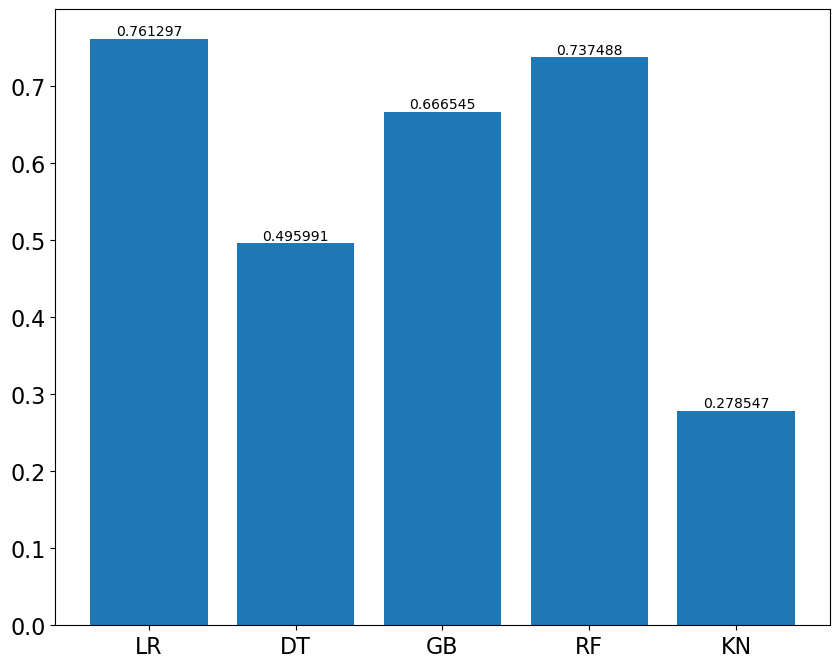

In [38]:
x, y = compare_models['model'],compare_models['accuracy']
ind = np.arange(len(y))
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(ind, y)
ax.set_xticks(ind)
ax.set_xticklabels(x)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()
#fig.savefig('Comparision of Models, TFIDF.pdf', format='pdf', bbox_inches = "tight")

## BoW

In [39]:
train = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1')
test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding='latin-1')

In [40]:
train=train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1)



In [41]:
dff = train.drop(['Sentiment'], axis = 1)


In [42]:
X_temp, X_test, y_temp, y_test = train_test_split(dff, list(train.Sentiment), test_size=0.2)


In [43]:
X_test.shape, X_temp.shape, len(y_test), len(y_temp)


((8232, 1), (32925, 1), 8232, 32925)

In [44]:
X_temp['label'] = y_temp


In [45]:
X_temp.head()

,OriginalTweet,label
39397,Let's talk covid-19 and its impact on online s...,Positive
40853,"Brain, Nervous System Affected in 1 in 3 Cases...",Extremely Negative
24186,"???URGENT. A large, multi-site trial exploring...",Positive
30760,?? 2nd walk of the day\r\r\n??? Sunbathing\r\r...,Neutral
23108,We can fight against COVID 19 only by keeping ...,Negative


In [46]:
Positive = X_temp[X_temp['label'] == 'Positive']
Negative = X_temp[X_temp['label'] == 'Negative']
Neutral = X_temp[X_temp['label'] == 'Neutral']
Extremely_Negative = X_temp[X_temp['label'] == 'Extremely Negative']
Extremely_Positive = X_temp[X_temp['label'] == 'Extremely Positive']

Positive.shape[0], Negative.shape[0], Neutral.shape[0], Extremely_Negative.shape[0], Extremely_Positive.shape[0]

(9098, 8006, 6150, 4413, 5258)

In [47]:
ds = pd.concat([Positive, Negative, Neutral, Extremely_Negative, Extremely_Positive], axis = 0)


In [48]:
ds


,OriginalTweet,label
39397,Let's talk covid-19 and its impact on online s...,Positive
24186,"???URGENT. A large, multi-site trial exploring...",Positive
33810,Current property prices should not be given to...,Positive
2176,I was just helping an elderly gentleman in @Te...,Positive
8117,Wearing a mask is not a crime. #coronavirus ht...,Positive
...,...,...
30813,Also...and I know I keep posting this but it's...,Extremely Positive
33716,Be careful when you are using hand sanitizer b...,Extremely Positive
32271,#JackDaniels created hand sanitizer and will d...,Extremely Positive
28138,You ve probably heard the news by now the go...,Extremely Positive


In [49]:
testdf = X_test
testdf['label'] = y_test
testdf.shape

(8232, 2)

In [50]:
len(testdf[testdf['label']=='Positive']),len(testdf[testdf['label']=='Negative']),len(testdf[testdf['label']=='Neutral']),len(testdf[testdf['label']=='Extremely Negative']),len(testdf[testdf['label']=='Extremely Positive'])


(2324, 1911, 1563, 1068, 1366)

In [51]:
ds = pd.concat([ds, testdf], axis = 0)


In [52]:
ds[ds['label']=='Positive'].shape, ds[ds['label']=='Negative'].shape, ds[ds['label']=='Neutral'].shape, ds[ds['label']=='Extremely Negative'].shape, ds[ds['label']=='Extremely Positive'].shape


((11422, 2), (9917, 2), (7713, 2), (5481, 2), (6624, 2))

In [53]:
corpus = []
for i in range(ds.shape[0]):
    corpus.append(ds.iloc[i][0])

In [54]:
vectorizer_train = CountVectorizer(max_features=1000)
vocabulary_train = vectorizer_train.fit_transform(corpus)
bow = pd.DataFrame(vocabulary_train.toarray(), columns = vectorizer_train.get_feature_names_out())

In [55]:
bow['labelxyz'] = list(ds.label)

In [56]:
bow_positive = bow[bow.labelxyz == 'Positive']
bow_negative = bow[bow.labelxyz == 'Negative']
bow_neutral = bow[bow.labelxyz == 'Neutral']
bow_extremely_negative = bow[bow.labelxyz == 'Extremely Negative']
bow_extremely_positive = bow[bow.labelxyz == 'Extremely Positive']



X_train_positive = bow_positive.sample(frac=0.8, random_state=0)
X_test_positive = bow_positive.drop(X_train_positive.index)
X_train_negative = bow_negative.sample(frac=0.8, random_state=0)
X_test_negative = bow_negative.drop(X_train_negative.index)
X_train_neutral = bow_neutral.sample(frac=0.8, random_state=0)
X_test_neutral = bow_neutral.drop(X_train_neutral.index)
X_train_extremely_negative = bow_extremely_negative.sample(frac=0.8, random_state=0)
X_test_extremely_negative = bow_extremely_negative.drop(X_train_extremely_negative.index)
X_train_extremely_positive = bow_extremely_positive.sample(frac=0.8, random_state=0)
X_test_extremely_positive = bow_extremely_positive.drop(X_train_extremely_positive.index)

X_train_df = pd.concat([X_train_positive, X_train_negative, X_train_neutral, X_train_extremely_negative, X_train_extremely_positive], axis = 0)
bow_train = X_train_df.drop(['labelxyz'], axis = 1)
y_train = list(X_train_df.labelxyz)
X_test_df = pd.concat([X_test_positive, X_test_negative, X_test_neutral, X_test_extremely_negative, X_test_extremely_positive], axis = 0)
bow_test = X_test_df.drop(['labelxyz'], axis = 1)
y_test = list(X_test_df.labelxyz)

In [57]:
model = ['LR','RF','DT','KN','GB']
accuracy = {'BOW':[]}

# Models

## Logistic Regression

In [58]:
regressor_LR_bow = LogisticRegression(C= 1.0, penalty='l2', solver= 'liblinear')
regressor_LR_bow.fit(bow_train,y_train)
y_predict_LR_bow = regressor_LR_bow.predict(bow_test)
a=(regressor_LR_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_LR_bow))
print(metrics.classification_report(y_test, y_predict_LR_bow))
print(metrics.accuracy_score(y_test, y_predict_LR_bow))

[[ 576   25  310  100   85]
 [  18  848   62   60  337]
 [ 321   69  840  358  395]
 [  21   29  144 1151  198]
 [  79  395  345  382 1083]]
                    precision    recall  f1-score   support

Extremely Negative       0.57      0.53      0.55      1096
Extremely Positive       0.62      0.64      0.63      1325
          Negative       0.49      0.42      0.46      1983
           Neutral       0.56      0.75      0.64      1543
          Positive       0.52      0.47      0.49      2284

          accuracy                           0.55      8231
         macro avg       0.55      0.56      0.55      8231
      weighted avg       0.54      0.55      0.54      8231

0.5464706597011298


## Random Forest

In [59]:
model_RF_bow = RandomForestClassifier(max_features='sqrt', n_estimators= 1000)
model_RF_bow.fit(bow_train,y_train)
y_predict_RF_bow = model_RF_bow.predict(bow_test)
a=(model_RF_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_RF_bow))
print(metrics.classification_report(y_test, y_predict_RF_bow))
print(metrics.accuracy_score(y_test, y_predict_RF_bow))

[[ 419   20  397   73  187]
 [  14  594   79   52  586]
 [ 179   44  939  309  512]
 [   7   18  184  968  366]
 [  54  191  368  313 1358]]
                    precision    recall  f1-score   support

Extremely Negative       0.62      0.38      0.47      1096
Extremely Positive       0.69      0.45      0.54      1325
          Negative       0.48      0.47      0.48      1983
           Neutral       0.56      0.63      0.59      1543
          Positive       0.45      0.59      0.51      2284

          accuracy                           0.52      8231
         macro avg       0.56      0.51      0.52      8231
      weighted avg       0.54      0.52      0.52      8231

0.519742437127931


## Decision Tree

In [60]:
model_DT_bow = DecisionTreeClassifier(criterion= 'gini', max_depth= 2) 
model_DT_bow.fit(bow_train,y_train)
y_predict_DT_bow = model_DT_bow.predict(bow_test)
a=(model_DT_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_DT_bow))
print(metrics.classification_report(y_test, y_predict_DT_bow))
print(metrics.accuracy_score(y_test, y_predict_DT_bow))

[[ 344    0    0    0  752]
 [  43    0    0    0 1282]
 [ 292    0    0    0 1691]
 [  25    0    0    0 1518]
 [ 108    0    0    0 2176]]
                    precision    recall  f1-score   support

Extremely Negative       0.42      0.31      0.36      1096
Extremely Positive       0.00      0.00      0.00      1325
          Negative       0.00      0.00      0.00      1983
           Neutral       0.00      0.00      0.00      1543
          Positive       0.29      0.95      0.45      2284

          accuracy                           0.31      8231
         macro avg       0.14      0.25      0.16      8231
      weighted avg       0.14      0.31      0.17      8231

0.30615964038391447


## K Neighbours

In [61]:
model_KN_bow = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 19, weights= 'distance') 
model_KN_bow.fit(bow_train,y_train)
y_predict_KN_bow = model_KN_bow.predict(bow_test)
a=(model_KN_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_KN_bow))
print(metrics.classification_report(y_test, y_predict_KN_bow))
print(metrics.accuracy_score(y_test, y_predict_KN_bow))

[[  71    3  245  672  105]
 [   6   64  119  829  307]
 [  32    3  351 1411  186]
 [   5    5   66 1402   65]
 [  10   19  226 1636  393]]
                    precision    recall  f1-score   support

Extremely Negative       0.57      0.06      0.12      1096
Extremely Positive       0.68      0.05      0.09      1325
          Negative       0.35      0.18      0.23      1983
           Neutral       0.24      0.91      0.37      1543
          Positive       0.37      0.17      0.24      2284

          accuracy                           0.28      8231
         macro avg       0.44      0.27      0.21      8231
      weighted avg       0.42      0.28      0.22      8231

0.27712307131575753


## Gradient Boosting

In [62]:
model_GB_bow = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 100, subsample= 1.0)
model_GB_bow.fit(bow_train,y_train)
y_predict_GB_bow = model_GB_bow.predict(bow_test)
a=(model_GB_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_GB_bow))
print(metrics.classification_report(y_test, y_predict_GB_bow))
print(metrics.accuracy_score(y_test, y_predict_GB_bow))

[[ 438   17  325   97  219]
 [  18  584   56   77  590]
 [ 231   36  732  387  597]
 [   6   12   82  918  525]
 [  58  179  317  383 1347]]
                    precision    recall  f1-score   support

Extremely Negative       0.58      0.40      0.47      1096
Extremely Positive       0.71      0.44      0.54      1325
          Negative       0.48      0.37      0.42      1983
           Neutral       0.49      0.59      0.54      1543
          Positive       0.41      0.59      0.48      2284

          accuracy                           0.49      8231
         macro avg       0.54      0.48      0.49      8231
      weighted avg       0.51      0.49      0.49      8231

0.48827602964402866


## Evaluation

In [63]:
data_bow = {'model':model,'accuracy':accuracy['BOW']}
compare_models_bow = pd.DataFrame(data_bow)
compare_models_bow

,model,accuracy
0,LR,0.546471
1,RF,0.519742
2,DT,0.306160
3,KN,0.277123
4,GB,0.488276


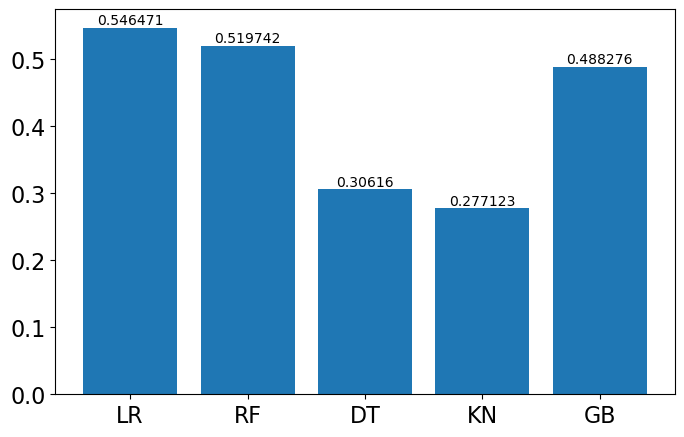

In [64]:
x, y = compare_models_bow['model'],compare_models_bow['accuracy']
ind = np.arange(len(y))
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(ind, y)
ax.set_xticks(ind)
ax.set_xticklabels(x)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()
fig.savefig('Comparision of Models, BoW.pdf', format='pdf')

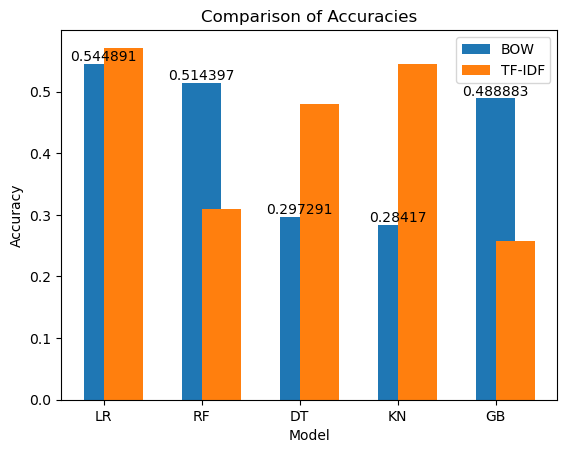

In [65]:

position1 = range(len(model))
position2 = [x + 0.2 for x in position1]  # Shifted by 0.2 for side-by-side placement

# Create the figure and axes
fig, ax = plt.subplots()
accuracy1 = [0.571186, 0.309281, 0.479956, 0.544461, 0.258017]
accuracy2 = [0.544891, 0.514397, 0.297291, 0.284170, 0.488883]

# Plot the bars
ax.bar(position1, accuracy2, width=0.4, label='BOW')
ax.bar(position2, accuracy1, width=0.4, label='TF-IDF')

# Set the x-axis tick positions and labels
ax.set_xticks(position1)
ax.set_xticklabels(model)
ax.bar_label(ax.containers[0])
# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Accuracies')

# Add a legend
ax.legend()

# Show the plot
plt.show()